In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

from scipy.io import savemat, loadmat

sec2year   = 365.25 * 24 * 60 * 60
psi2pascal = 6894.76
co2_rho    = 686.5266
mega       = 1e6

n_timesteps = 33
nx, ny, nz  = 100, 100, 11

In [9]:
### VE actnum
Jfolder = '/mnt/e/Placement-Control-Optim-CO2/Johansen/data'

actnum = np.loadtxt('{}/NPD5_ActiveCells.txt'.format(Jfolder), skiprows=1).flatten().reshape(nx,ny,nz, order='F')
actnum_pad = np.pad(actnum, ((14,14),(14,14),(2,3)), mode='constant', constant_values=0)

actnum_l1 = actnum[...,0]
indexMap_VE = np.argwhere(actnum_l1.flatten(order='F')).flatten(order='F')

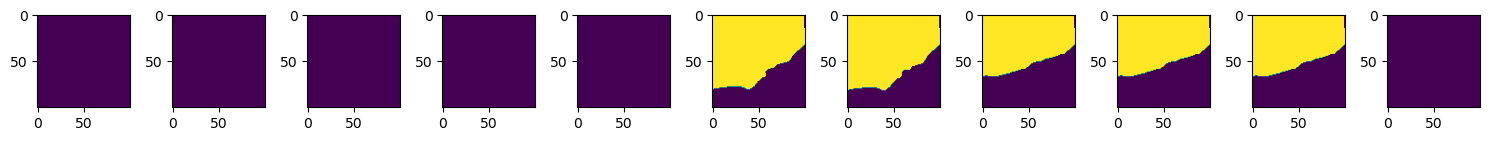

In [187]:
### 3D actnum
Grid = np.zeros((nx,ny,nz))
Grid_f = Grid.flatten(order='F')
indexMap = loadmat('data_100_100_11/G_cells_indexMap.mat', simplify_cells=True)['gci']

Grid_f[indexMap] = 1
Grid = Grid_f.reshape(nx,ny,nz, order='F')

plt.figure(figsize=(15,5))
for i in range(11):
    plt.subplot(1, 11, i+1)
    plt.imshow(Grid[...,i])
plt.tight_layout()
plt.show()

In [188]:
realization = 411

d = loadmat('data_100_100_11/states/states_{}.mat'.format(realization), simplify_cells=True)['var']
rock = loadmat('data_100_100_11/rock/rock_{}.mat'.format(realization), simplify_cells=True)
poro = rock['poro']
perm = rock['perm']

wid = np.zeros((2,5), dtype='int')
w = loadmat('data_100_100_11/well_coords/well_coords_{}.mat'.format(realization), simplify_cells=True)['var']
wlist = np.array(list(w.values()))
wlist = wlist.reshape(-1, 1) if wlist.ndim == 1 else wlist
for i in range(wlist.shape[-1]):
    wid[:,i] = wlist[:,i]

In [259]:
poro_masked = np.ma.masked_where(Grid==0, poro)
perm_masked = np.ma.masked_where(Grid==0, perm)

m_ensemble = np.ma.concatenate([np.expand_dims(poro_masked, 0),
                                np.expand_dims(perm_masked, 0)], axis=0)[...,5:10]

print('m_ensemble: {}'.format(m_ensemble.shape))

m_ensemble: (2, 100, 100, 5)


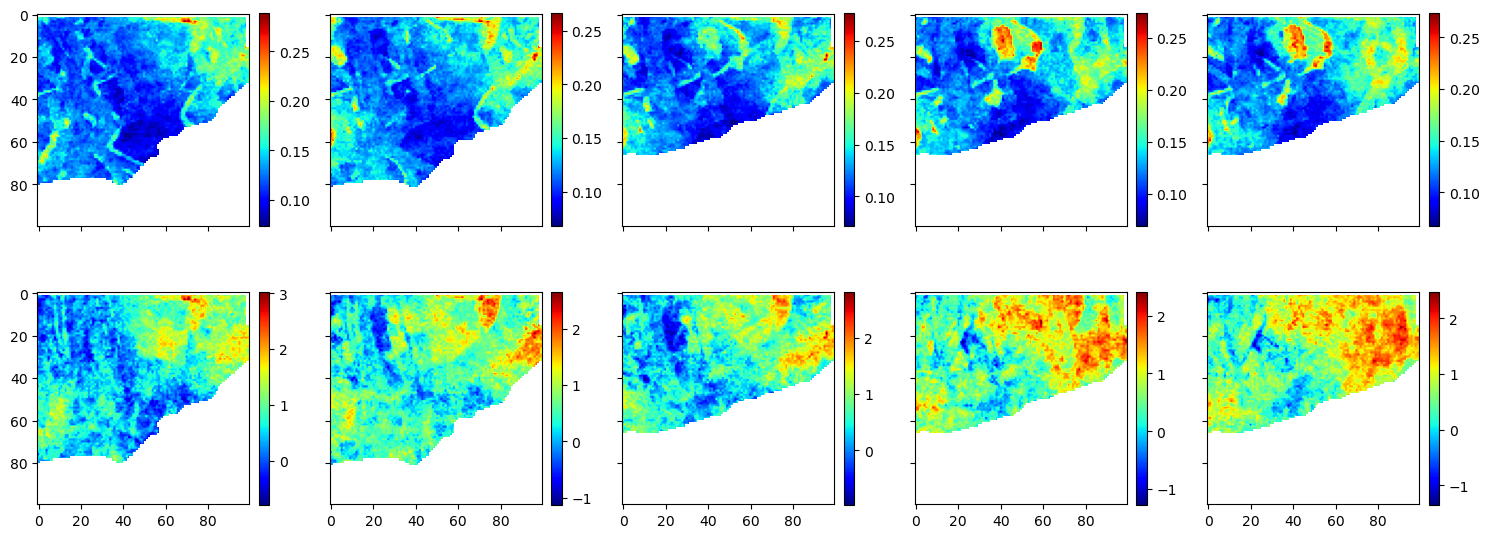

In [260]:
fig, axs = plt.subplots(2, 5, figsize=(15,6), sharex=True, sharey=True)
for j in range(5):
    ax1, ax2 = axs[0,j], axs[1,j]
    im1 = ax1.imshow(m_ensemble[0,:,:,j], cmap='jet')
    im2 = ax2.imshow(m_ensemble[1,:,:,j], cmap='jet')
    [plt.colorbar(i, pad=0.04, fraction=0.046) for i in [im1, im2]]
plt.tight_layout()
plt.show()

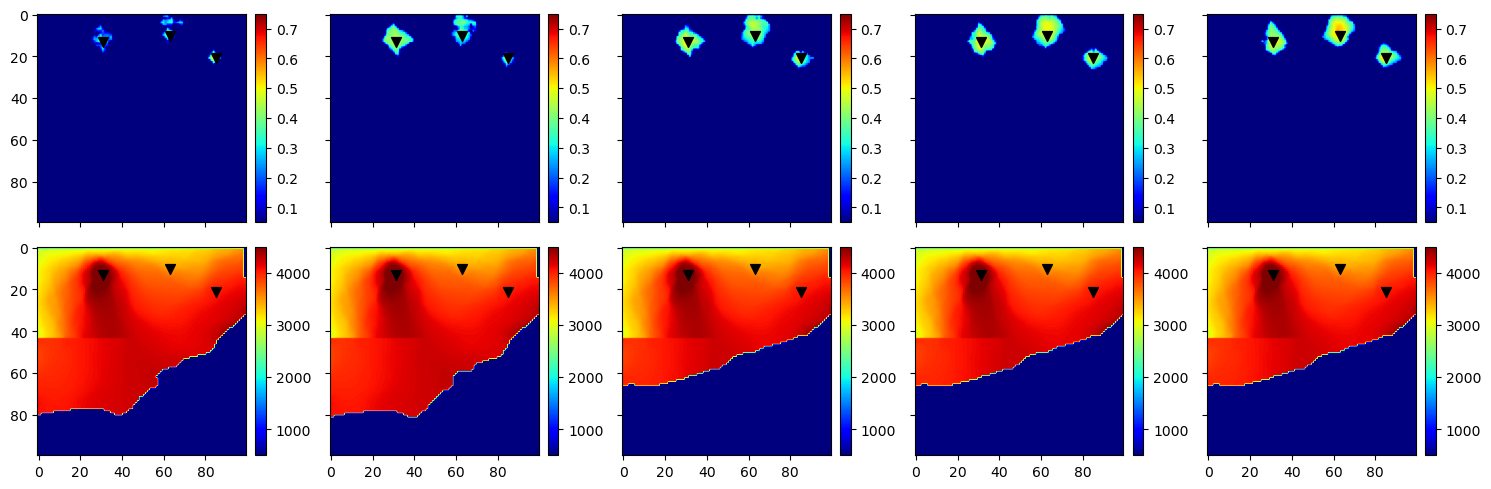

In [287]:
smap = np.zeros((100,100,11)).flatten(order='F')
smap[indexMap] = d[-1]['s'][:,1]
smap = smap.reshape(100,100,11, order='F')[...,5:10]

pmap = np.zeros((100,100,11)).flatten(order='F')
pmap[indexMap] = d[-1]['pressure'] / psi2pascal
pmap = pmap.reshape(100,100,11, order='F')[...,5:10]

fig, axs = plt.subplots(2, 5, figsize=(15,5), sharex=True, sharey=True)
for j in range(5):
    ax1, ax2 = axs[0,j], axs[1,j]
    im1 = ax1.imshow(smap[...,j], cmap='jet', vmin=0.05, vmax=0.75)
    im2 = ax2.imshow(pmap[...,j], cmap='jet', vmin=500, vmax=4500)
    [plt.colorbar(i, pad=0.04, fraction=0.046) for i in [im1, im2]]
    for w in range(wlist.shape[-1]):
        [a.scatter(wid[1,w], wid[0,w], c='k', s=50, marker='v') for a in [ax1, ax2]]
plt.tight_layout()
plt.show()

In [153]:
wctrl = np.zeros((n_timesteps,5))
k = 0
for t in range(1,n_timesteps+1):
    for w in range(wlist.shape[-1]):
        if wlist.shape[-1] == 1:
            wctrl[t-1,w] = d[t]['wellSol']['val'] * co2_rho * sec2year / 1e3 / mega
        else:
            wctrl[t-1,w] = d[t]['wellSol'][w]['val'] * co2_rho * sec2year / 1e3 / mega

In [154]:
timesteps = np.zeros((n_timesteps,1))
for t in range(n_timesteps):
    timesteps[t] = d[t+1]['time'] / sec2year

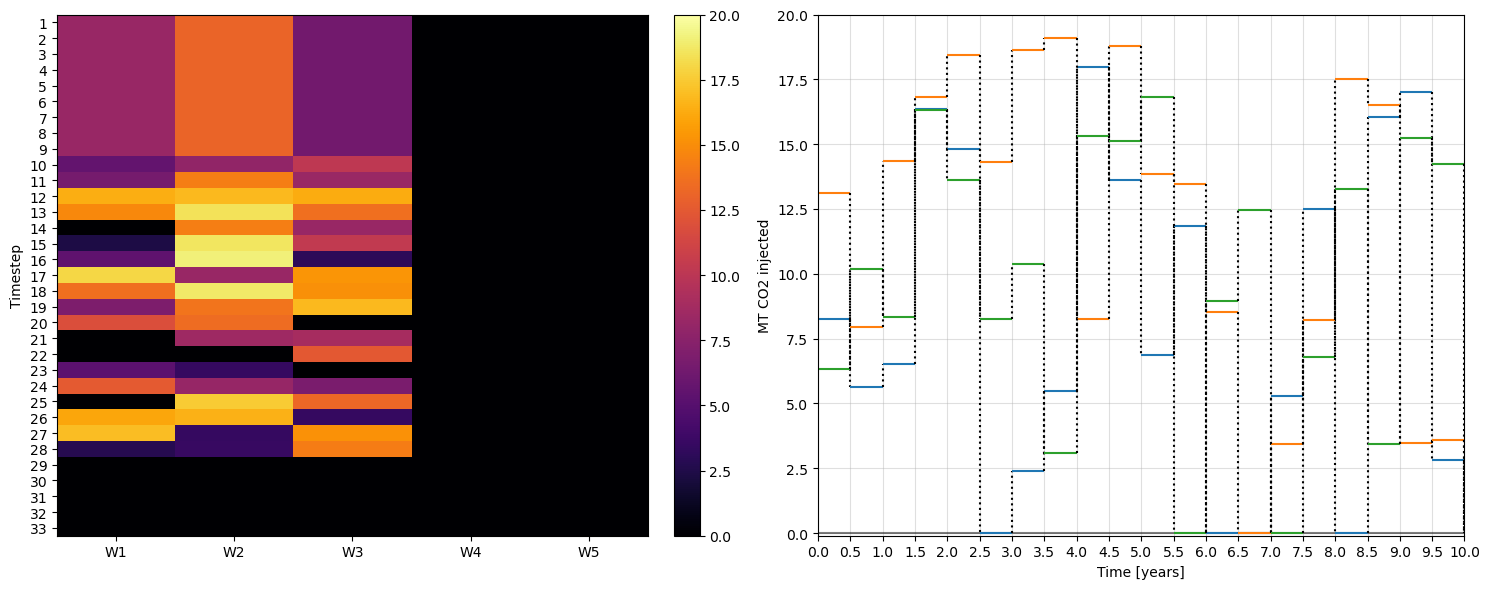

In [160]:
plt.figure(figsize=(15,6))

plt.subplot(121)
im = plt.imshow(wctrl, cmap='inferno', aspect='auto', vmin=0, vmax=20)
plt.xticks(np.arange(5), ['W{}'.format(i+1) for i in range(5)])
plt.yticks(np.arange(33), np.arange(1,34))
plt.ylabel('Timestep')
plt.colorbar(im, pad=0.04, fraction=0.046)

plt.subplot(122)
plt.hlines(0, 0, 10, color='k', alpha=0.5)
for w in range(wlist.shape[-1]):
    for t in range(1,28):
        lh = plt.hlines(wctrl[t,w], timesteps[t-1], timesteps[t], color='C{}'.format(w))
        lv = plt.vlines(timesteps[t], wctrl[t,w], wctrl[t+1,w], color='k', ls=':')
plt.xticks(np.arange(10.5, step=0.5))
plt.xlabel('Time [years]')
plt.ylabel('MT CO2 injected')
plt.xlim(0, 10)
plt.ylim(-0.1, 20)
plt.grid(True, which='both', alpha=0.4)
plt.tight_layout()
plt.show()

In [130]:
schedule = loadmat('schedule.mat', simplify_cells=True)['schedule']
print(schedule.keys())

nw = len(schedule['control'][0]['W'])
print('# wells: {}'.format(nw))

dict_keys(['control', 'step'])
# wells: 2


In [141]:
time = schedule['step']['val']/sec2year
cumtime = np.cumsum(time)
print(time)
print(cumtime)

[0.00195308 0.00195308 0.00390617 0.00781234 0.01562468 0.03124936
 0.06249872 0.12499743 0.24999487 0.49998973 0.49998973 0.49998973
 0.49998973 0.49998973 0.49998973 0.49998973 0.49998973 0.49998973
 0.49998973 0.49998973 0.49998973 0.49998973 0.49998973 0.49998973
 0.49998973 0.49998973 0.49998973 0.49998973]
[1.95308489e-03 3.90616979e-03 7.81233958e-03 1.56246792e-02
 3.12493583e-02 6.24987166e-02 1.24997433e-01 2.49994867e-01
 4.99989733e-01 9.99979466e-01 1.49996920e+00 1.99995893e+00
 2.49994867e+00 2.99993840e+00 3.49992813e+00 3.99991786e+00
 4.49990760e+00 4.99989733e+00 5.49988706e+00 5.99987680e+00
 6.49986653e+00 6.99985626e+00 7.49984600e+00 7.99983573e+00
 8.49982546e+00 8.99981520e+00 9.49980493e+00 9.99979466e+00]


In [132]:
cval = schedule['step']['control']
cval

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype=uint8)

In [134]:
ctrl = np.zeros((28,nw))
for i in range(28):
    for w in range(nw):
        ctrl[i,w] = schedule['control'][i]['W'][w]['val']
print(ctrl.shape)

(28, 2)


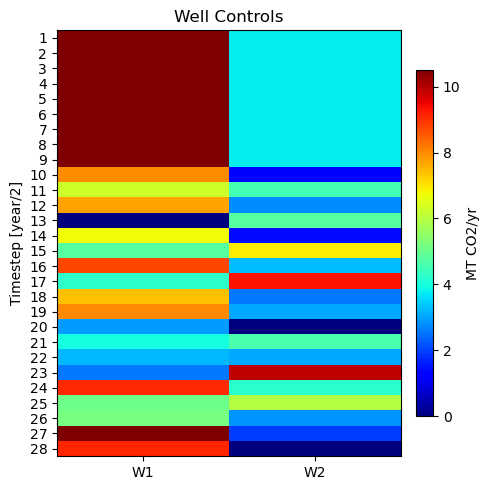

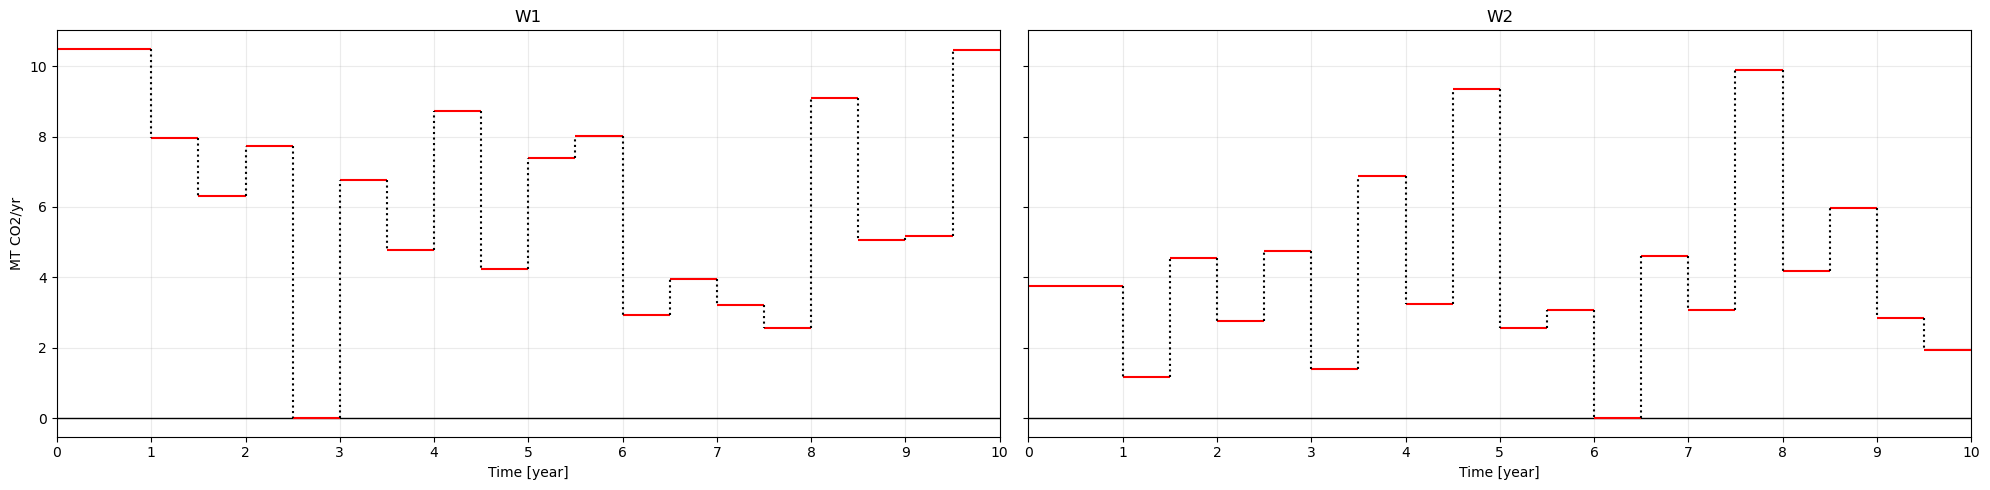

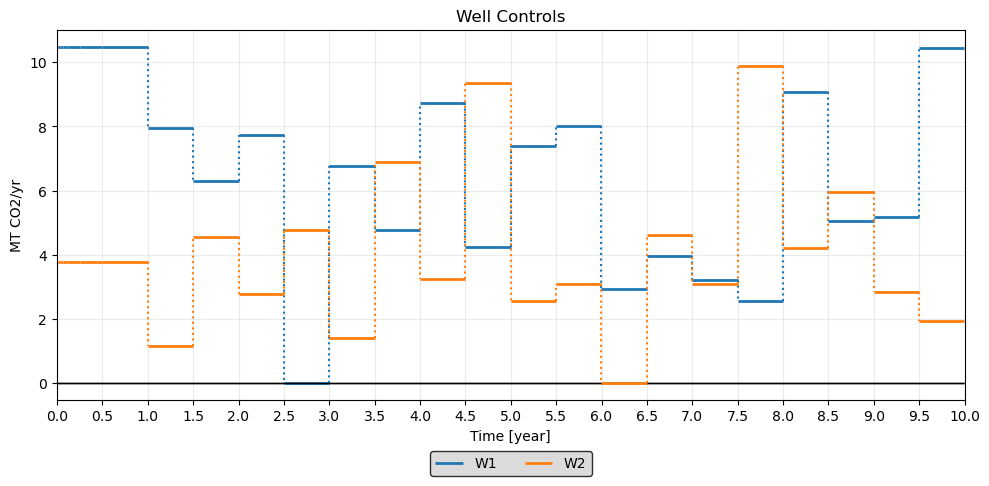

In [182]:
plt.figure(figsize=(5,5))
im = plt.imshow(ctrl*co2_rho*sec2year/mega/1e3, cmap='jet', aspect='auto')
plt.colorbar(im, pad=0.04, fraction=0.046, label='MT CO2/yr')
plt.yticks(range(28), labels=range(1,29))
plt.xticks(range(ctrl.shape[1]), labels=['W{}'.format(i) for i in range(1,1+ctrl.shape[1])])
plt.ylabel('Timestep [year/2]')
plt.title('Well Controls')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, nw, figsize=(20,5), sharex=True, sharey=True)
for i in range(ctrl.shape[1]):
    axs[i].hlines(0, 0, cumtime[-1], color='k', lw=1)
    for t in range(1,27):
        axs[i].hlines(ctrl[t,i]*co2_rho*sec2year/mega/1e3, cumtime[t], cumtime[t+1], color='r')
        axs[i].vlines(cumtime[t], ctrl[t-1,i]*co2_rho*sec2year/mega/1e3, ctrl[t,i]*co2_rho*sec2year/mega/1e3, color='k', ls=':')
    axs[i].set_xticks(np.linspace(0, 10, 11, dtype='int'))
    axs[i].grid(True, which='both', alpha=0.25)
    axs[i].set(xlabel='Time [year]', title='W{}'.format(i+1), xlim=(0,10))
axs[0].set_ylabel('MT CO2/yr')
plt.tight_layout()
plt.show()

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
handle = []
plt.figure(figsize=(10,5))
for i in range(ctrl.shape[1]):
    plt.hlines(0, 0, cumtime[-1], color='k', lw=1)
    for t in range(1,27):
        ln = plt.hlines(ctrl[t,i]*co2_rho*sec2year/mega/1e3, cumtime[t], cumtime[t+1], color=colors[i], lw=2)
        handle.append(ln) if t == 1 else None
        plt.vlines(cumtime[t], ctrl[t-1,i]*co2_rho*sec2year/mega/1e3, ctrl[t,i]*co2_rho*sec2year/mega/1e3, color=colors[i], ls=':')
plt.legend(handle, ['W{}'.format(i+1) for i in range(ctrl.shape[1])], bbox_to_anchor=(0.5, -0.225), loc='lower center', ncols=nw, facecolor='lightgrey', edgecolor='k')
plt.xticks(np.linspace(0, 10, 21), labels=np.linspace(0, 10, 21))
plt.grid(True, which='both', alpha=0.25)
plt.xlabel('Time [year]')
plt.ylabel('MT CO2/yr')
plt.xlim(0,10)
plt.title('Well Controls')
plt.tight_layout()
plt.show()

poro: (100, 100, 11) | perm: (100, 100, 11)


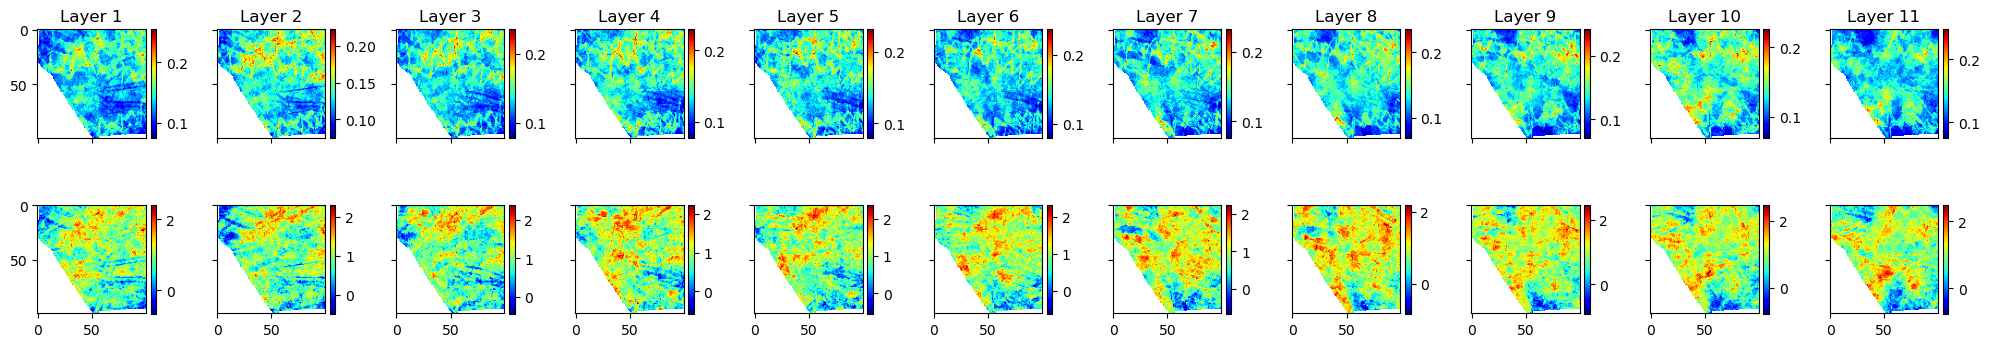

In [4]:
rock = loadmat('data_100_100_11/rock/rock_69.mat')
poro = np.rot90(rock['poro'], 3)
perm = np.rot90(rock['perm'], 3)
print('poro: {} | perm: {}'.format(poro.shape, perm.shape))

fig, axs = plt.subplots(2, 11, figsize=(20,4), sharex=True, sharey=True)
for j in range(11):
    p = np.flip(np.ma.masked_where(actnum_l1==0, poro[:,:,j]),1)
    k = np.flip(np.ma.masked_where(actnum_l1==0, perm[:,:,j]),1)
    im0 = axs[0,j].imshow(p, cmap='jet')
    im1 = axs[1,j].imshow(k, cmap='jet')
    [plt.colorbar(i, pad=0.04, fraction=0.046) for i in [im0, im1]]
    axs[0,j].set_title('Layer {}'.format(j+1))
plt.tight_layout()
plt.show()

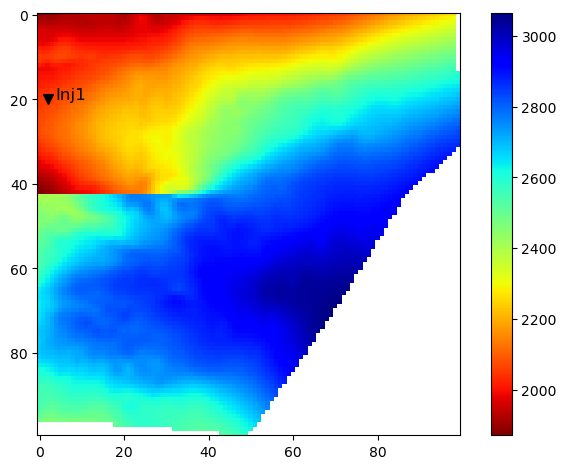

In [12]:
wc = np.array(list(loadmat('data_100_100_11/well_coords/well_coords_69.mat', simplify_cells=True)['var'].values()))

tops = loadmat('data_100_100_11/Gt_cells_z.mat', simplify_cells=True)['gtz']
tops_grid = np.zeros((100,100))
tops_grid_f = tops_grid.flatten(order='F')
tops_grid_f[indexMap] = tops
tops_grid = tops_grid_f.reshape(100,100,order='F')
tops_grid_masked = np.ma.masked_where(actnum_l1==0, tops_grid)

plt.scatter(wc[1,:], wc[0,:], color='k', marker='v', s=50) if len(wc.shape) > 1 else plt.scatter(wc[1], wc[0], color='k', marker='v', s=50)
[plt.text(wc[1,i]+9, wc[0,i], 'Inj{}'.format(i+1), fontsize=12, color='k', ha='right') for i in range(wc.shape[1])] if len(wc.shape) > 1 else plt.text(wc[1]+9, wc[0], 'Inj1', fontsize=12, color='k', ha='right')
plt.imshow(tops_grid_masked, cmap='jet_r', interpolation='none')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
n_realizations = 3
timesteps = []
saturation_f = np.zeros((n_realizations,31,29128))
pressure_f   = np.zeros((n_realizations,31,29128))

sec2year = 365.25 * 24 * 60 * 60
psi2pascal = 6894.76

for t in range(1,30):
    d = loadmat('data_100_100_11/states/states_0.mat', simplify_cells=True)['var']
    timesteps.append(d[t]['time']/sec2year)
timesteps = [0] + timesteps

for i in range(n_realizations):
    d = loadmat('data_100_100_11/states/states_{}.mat'.format(i), simplify_cells=True)['var']
    for t in range(len(d)):
        saturation_f[i,t] = d[t]['s'][:,1]
        pressure_f[i,t]   = d[t]['pressure']

In [ ]:
indexMap = loadmat('data_100_100_11/G_cells_indexMap.mat', simplify_cells=True)['G_cells_indexMap']

In [ ]:
saturation = np.zeros((n_realizations, len(timesteps), 100*100*11))
pressure   = np.zeros((n_realizations, len(timesteps), 100*100*11))

for i in range(n_realizations):
    for t in range(len(timesteps)):
        saturation[i,t][indexMap] = saturation_f[i,t][::-1]
        pressure[i,t][indexMap]   = pressure_f[i,t] / psi2pascal

saturation = saturation.reshape(n_realizations, len(timesteps), 11, 100, 100)
pressure   = pressure.reshape(n_realizations, len(timesteps), 11, 100, 100)
print(saturation.shape, pressure.shape)

In [ ]:
well_rates = {}
for i in range(n_realizations):
    d = loadmat('data_100_100_11/VE_states/states_{}.mat'.format(i), simplify_cells=True)['var']
    d0 = d[1]['wellSol']
    nw = 1 if len(d0) > 3 else len(d0)
    wr = np.zeros((len(timesteps), nw))
    for w in range(nw):
        for t in range(1,len(timesteps)):
            wr[t,w] = d[t]['wellSol'][w]['val'] if nw > 1 else  d[t]['wellSol']['val']
    well_rates[i] = wr * co2_rho * sec2year / 1e3 / mega

In [13]:
d131 = loadmat('data_100_100_11/states/states_69.mat', simplify_cells=True)['var']

timesteps = []
for i in range(39):
    t = d131[i]['time']
    timesteps.append(t/sec2year)

d0 = d131[1]['wellSol']
nw = 1 if len(d0) > 3 else len(d0)
wr = np.zeros((len(timesteps), nw))
for w in range(nw):
    for t in range(1,len(timesteps)):
        wr[t,w] = d131[t]['wellSol'][w]['val'] if nw > 1 else  d131[t]['wellSol']['val']

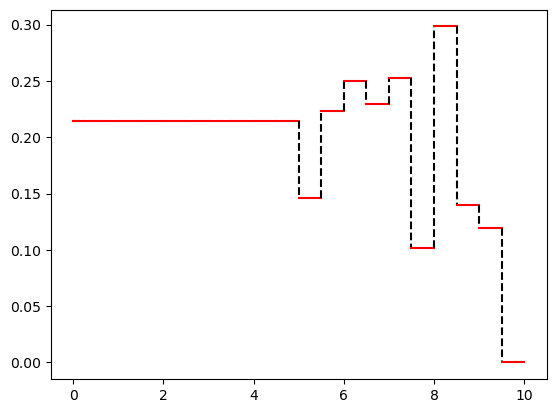

In [15]:
for t in range(1,29):
    plt.plot([timesteps[t-1], timesteps[t]], [wr[t,w], wr[t,w]], 'r')
    plt.vlines(timesteps[t], wr[t,w], wr[t+1,w], ls='--', color='k')   

TypeError: 'Axes' object is not subscriptable

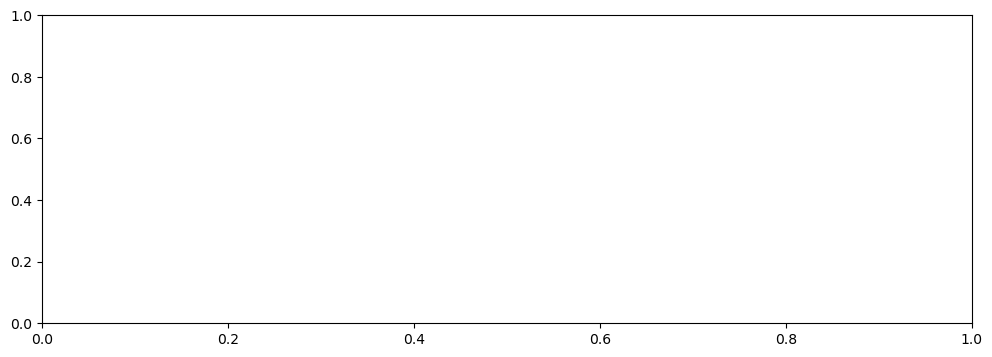

In [14]:
fig, axs = plt.subplots(1, wr.shape[1], figsize=(12,4), sharex=True, sharey=True)
for w in range(wr.shape[1]):
    ax = axs[w]
    ax.set(xlabel='Time [years]', xticks=range(11), xticklabels=range(11), xlim=(0,10), title='Injector {}'.format(w+1))
    ax.set_ylabel('Injection rate [Mt CO2/year]', c='r')
    ax.grid(True, which='both', alpha=0.5)
    ax2 = ax.twinx()
    ax2.plot(timesteps[:29], np.cumsum(wr[:29,w]*timesteps[:29]), color='b', marker='.')
    ax2.set_ylabel('Cumulative CO2 Injected [Mt]', color='b', rotation=270, labelpad=15)
    for t in range(1,29):
        ax.plot([timesteps[t-1], timesteps[t]], [wr[t,w], wr[t,w]], 'r')
        ax.vlines(timesteps[t], wr[t,w], wr[t+1,w], ls='--', color='k')    
plt.tight_layout()
plt.show()

In [16]:
sat0 = np.zeros((100*100*11))
pres0 = np.zeros((100*100*11))

sat0[indexMap] = np.ma.masked_where(indexMap, d131[-1]['s'][:,1])
s0 = np.moveaxis(sat0.reshape(11,100,100), 0, -1)
s0 = np.ma.masked_where(actnum==0, s0)

pres0[indexMap] = np.ma.masked_where(indexMap, d131[-1]['pressure'])
p0 = np.moveaxis(pres0.reshape(11,100,100), 0, -1)
p0 = np.ma.masked_where(actnum==0, p0)

plt.figure(figsize=(20,6))
for i in range(11):
    plt.subplot(1, 11, i+1)
    plt.imshow(s0[...,i], cmap='jet', vmin=0, vmax=0.7)
    plt.scatter(wc[0,:], wc[1,:], color='k', marker='v', s=25)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,6))
for i in range(11):
    plt.subplot(1, 11, i+1)
    plt.imshow(p0[...,i], cmap='jet_r')
    plt.scatter(wc[0,:], wc[1,:], color='k', marker='v', s=25)
plt.tight_layout()
plt.show()

IndexError: Inconsistent shape between the condition and the input (got (8072,) and (29128,))

In [ ]:
realization = 2

plt.figure(figsize=(20,7))
k = 0
for i in range(3):
    for j in range(10):
        plt.subplot(3,10,k+1)
        sat_masked = np.ma.masked_where(actnum_l1==0, saturation[realization,k,5])
        im = plt.imshow(sat_masked, cmap='jet', vmin=0, vmax=0.25)
        plt.title('t={:.1f}'.format(round(timesteps[k], 2)))
        plt.colorbar(im, pad=0.04, fraction=0.046)
        plt.xticks([]); plt.yticks([])
        k += 1
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20,7))
k = 0
for i in range(4):
    for j in range(10):
        plt.subplot(4,10,k+1)
        k += 1
        pres_masked = np.ma.masked_where(actnum_l1==0, pressure[realization,k])
        im = plt.imshow(pres_masked, cmap='jet')
        plt.title('t={:.1f}'.format(round(timesteps[k], 2)))
        plt.colorbar(im, pad=0.04, fraction=0.046)
        plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, well_rates[realization].shape[1], figsize=(12,4), sharex=True, sharey=True)
for w in range(well_rates[realization].shape[1]):
    ax = axs[w]
    ax.set(xlabel='Time [years]', xticks=range(11), xticklabels=range(11), xlim=(0,10), title='Injector {}'.format(w+1))
    ax.set_ylabel('Injection rate [Mt CO2/year]', c='r')
    ax.grid(True, which='both', alpha=0.5)
    ax2 = ax.twinx()
    ax2.plot(timesteps[:20], np.cumsum(well_rates[realization][:20,w]*timesteps[:20]), color='b', marker='.')
    ax2.set_ylabel('Cumulative CO2 Injected [Mt]', color='b', rotation=270, labelpad=15)
    for t in range(1,21):
        ax.plot([timesteps[t-1], timesteps[t]], [well_rates[realization][t,w], well_rates[realization][t,w]], 'r')
        ax.vlines(timesteps[t], well_rates[realization][t,w], well_rates[realization][t+1,w], ls='--', color='k')    
plt.tight_layout()
plt.show()

In [ ]:
report = loadmat('data_100_100_11/VE_reports_NoFlowBC/reports_21.mat', simplify_cells=True)['var']
sec2year = 365.25 * 24 * 60 * 60
mt_of_co2 = 686.5266 * 1e6

t = []
for i in range(31):
    t.append(report[i]['t']/sec2year)

m = np.zeros((31,8))
for i in range(31):
    for j in range(8):
        m[i,j] = report[i]['masses'][j] / mt_of_co2

In [ ]:
colors = ['k','blue','green','lightgreen','gold','c','orange','r']
labels = ['dissolved','structural residual', 'residual','residual in plume','structural plume', 'structural plume (t)','free plume', 'exited']

for i in range(8):
    plt.plot(t, np.cumsum(m, axis=1), color='k', lw=0.25)
    plt.fill_between(t, np.cumsum(m, axis=1)[:,i], np.cumsum(m, axis=1)[:,i-1], label=labels[i], color=colors[i])

plt.vlines(10, 0, np.cumsum(m,1).max(), color='k', ls='--')
plt.text(12, 30, 'end of injection', bbox=dict(facecolor='lightgray', edgecolor='k'))

plt.xscale('log')
plt.xlim(0.5, 510)
plt.legend(bbox_to_anchor=(1.015, 0.5), loc='center left', facecolor='lightgrey', edgecolor='k')
plt.xlabel('Time [years]'); plt.ylabel('Mass CO2 [Mt]')
plt.grid(True, which='both', alpha=0.33)
plt.show()